# Sales Analysis - Step by Step (Beginner Friendly)

**Amaç:** Bu notebook, satış verileri üzerinde sıfırdan başlayarak adım adım Keşifsel Veri Analizi (EDA) yapmayı öğretir.

**İçerik:**
1. Ortam kurulumu ve kütüphanelerin yüklenmesi
2. Veriyi okuma ve ilk inceleme
3. Veri temizleme (tarih, eksikler, yinelenen satırlar)
4. Özellik çıkarımı (Ay, Yıl vb.)
5. Sık sorulan iş soruları (business questions) ve cevapları
6. Görselleştirmeler (tek grafik / chart başına tek plot)
7. Sonuçların `results/` klasörüne kaydedilmesi

## 0) Kurulum Kontrolü

Aşağıdaki komutu çalıştırarak kütüphanelerin doğru yüklendiğini test edin.

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.matplotlib.__version__)

# Çıktı görmüyorsanız, `pip install -r requirements.txt` komutu ile kurulum yapın.

Python: 3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]
NumPy: 2.3.3
Pandas: 2.3.2
Matplotlib: 3.10.6


## 1) Veriyi Yükleme

- `data/sales_sample.csv` dosyasını Pandas ile okuyacağız.
- Tarih alanını (OrderDate) `datetime` tipine çevireceğiz.

In [2]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("..") / "data" / "sales_sample.csv"
df = pd.read_csv(DATA_PATH)

# Tarih alanını datetime formatına çevir
df["OrderDate"] = pd.to_datetime(df["OrderDate"], errors="coerce")

df.head()

,OrderID,OrderDate,Country,City,Segment,Category,SubCategory,ProductName,Quantity,Discount,Sales,Profit
0,DE-20230817-0001,2023-08-17,DE,München,Corporate,Office Supplies,Storage,Storage #3286,3,0.00,84.69,17.71
1,DE-20240827-0002,2024-08-27,DE,München,Consumer,Furniture,Supplies,Supplies #7912,2,0.05,622.42,104.56
2,DE-20230827-0003,2023-08-27,DE,Berlin,Corporate,Office Supplies,Paper,Paper #9279,5,0.05,11.57,0.47
3,DE-20241027-0004,2024-10-27,DE,Bremen,Corporate,Office Supplies,Labels,Labels #9928,6,0.05,66.03,12.62
4,DE-20230107-0005,2023-01-07,DE,Düsseldorf,Home Office,Office Supplies,Art,Art #3615,3,0.00,30.27,5.89


## 2) Hızlı Genel Bakış

- Şema ve veri tipleri
- Sayısal sütunların özet istatistikleri
- Eksik değer kontrolü

In [3]:
display(df.info())
display(df.describe().T)
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderID      250 non-null    object        
 1   OrderDate    250 non-null    datetime64[ns]
 2   Country      250 non-null    object        
 3   City         250 non-null    object        
 4   Segment      250 non-null    object        
 5   Category     250 non-null    object        
 6   SubCategory  250 non-null    object        
 7   ProductName  250 non-null    object        
 8   Quantity     250 non-null    int64         
 9   Discount     250 non-null    float64       
 10  Sales        250 non-null    float64       
 11  Profit       250 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 23.6+ KB


None

,count,mean,min,25%,50%,75%,max,std
OrderDate,250,2023-12-24 22:27:50.400000,2023-01-07 00:00:00,2023-06-21 12:00:00,2023-12-19 00:00:00,2024-05-24 18:00:00,2024-12-27 00:00:00,NaN
Quantity,250.0,2.816,1.0,1.0,3.0,4.0,8.0,1.632422
Discount,250.0,0.0476,0.0,0.0,0.0,0.1,0.15,0.058891
Sales,250.0,578.61656,3.02,71.82,253.03,793.7575,4030.83,750.391333
Profit,250.0,80.64824,0.29,12.17,36.1,106.4725,495.3,100.596224


OrderID        0
OrderDate      0
Country        0
City           0
Segment        0
Category       0
SubCategory    0
ProductName    0
Quantity       0
Discount       0
Sales          0
Profit         0
dtype: int64

## 3) Veri Temizleme

- Geçersiz tarihleri düşür
- Yinelenen (duplicate) satır var mı?

In [4]:
# Geçersiz tarihleri çıkar
before = len(df)
df = df.dropna(subset=["OrderDate"])
after = len(df)
print(f"Geçersiz tarihli satırlar çıkarıldı: {before - after} satır.")

# Yinelenen satırlar
dups = df.duplicated().sum()
print("Yinelenen satır sayısı:", dups)
if dups > 0:
    df = df.drop_duplicates()
    print("Yinelenenler düşüldü. Yeni satır sayısı:", len(df))

Geçersiz tarihli satırlar çıkarıldı: 0 satır.
Yinelenen satır sayısı: 0


## 4) Özellik Çıkarımı (Feature Engineering)

- Yıl ve Ay sütunlarını oluştur
- Aylık gruplama için `YearMonth` (YYYY-MM) alanı

In [5]:
df["Year"] = df["OrderDate"].dt.year
df["Month"] = df["OrderDate"].dt.month
df["YearMonth"] = df["OrderDate"].dt.to_period("M").astype(str)

df.head()

,OrderID,OrderDate,Country,City,Segment,Category,SubCategory,ProductName,Quantity,Discount,Sales,Profit,Year,Month,YearMonth
0,DE-20230817-0001,2023-08-17,DE,München,Corporate,Office Supplies,Storage,Storage #3286,3,0.00,84.69,17.71,2023,8,2023-08
1,DE-20240827-0002,2024-08-27,DE,München,Consumer,Furniture,Supplies,Supplies #7912,2,0.05,622.42,104.56,2024,8,2024-08
2,DE-20230827-0003,2023-08-27,DE,Berlin,Corporate,Office Supplies,Paper,Paper #9279,5,0.05,11.57,0.47,2023,8,2023-08
3,DE-20241027-0004,2024-10-27,DE,Bremen,Corporate,Office Supplies,Labels,Labels #9928,6,0.05,66.03,12.62,2024,10,2024-10
4,DE-20230107-0005,2023-01-07,DE,Düsseldorf,Home Office,Office Supplies,Art,Art #3615,3,0.00,30.27,5.89,2023,1,2023-01


## 5) İş Soruları ve Cevaplar (EDA)

### Soru 1: En çok ciro (Sales) getiren kategoriler hangileri?

Category
Technology         79875.85
Furniture          59069.67
Office Supplies     5708.62
Name: Sales, dtype: float64


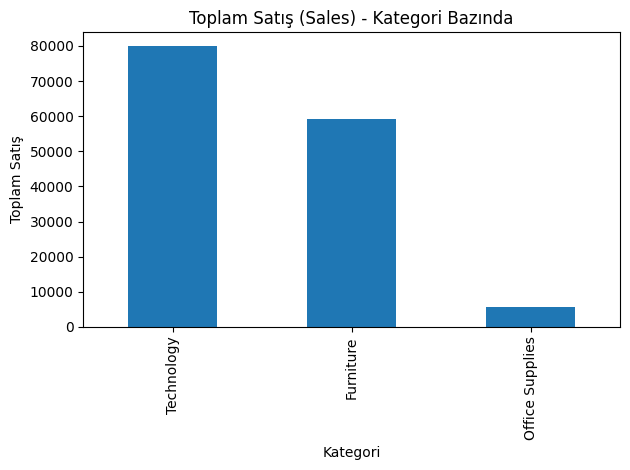

In [6]:
category_sales = df.groupby("Category")["Sales"].sum().sort_values(ascending=False)
print(category_sales)

# Çubuk grafik
plt.figure()
category_sales.plot(kind="bar")
plt.title("Toplam Satış (Sales) - Kategori Bazında")
plt.xlabel("Kategori")
plt.ylabel("Toplam Satış")
plt.tight_layout()
plt.show()

### Soru 2: Şehirlere göre ciro dağılımı nasıldır? İlk 10 şehir.

City
Stuttgart     22711.18
Köln          22035.18
Düsseldorf    21359.00
Leipzig       17100.87
München       16054.32
Bremen        13740.91
Dortmund       9000.30
Berlin         8588.23
Frankfurt      8511.29
Hamburg        5552.86
Name: Sales, dtype: float64


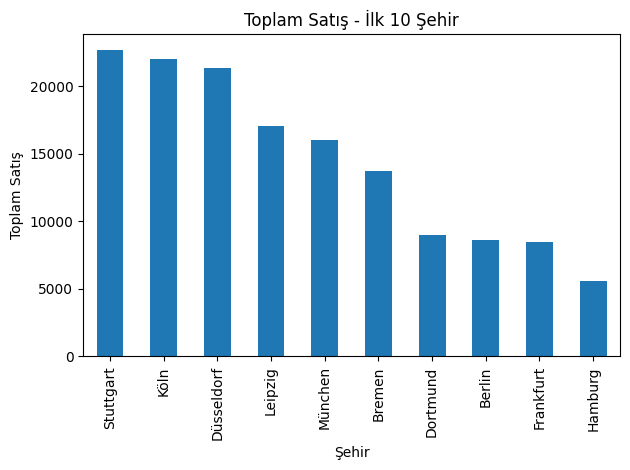

In [7]:
city_sales = df.groupby("City")["Sales"].sum().sort_values(ascending=False).head(10)
print(city_sales)

plt.figure()
city_sales.plot(kind="bar")
plt.title("Toplam Satış - İlk 10 Şehir")
plt.xlabel("Şehir")
plt.ylabel("Toplam Satış")
plt.tight_layout()
plt.show()

### Soru 3: Aylık satış trendi (tüm şehirler için toplam)

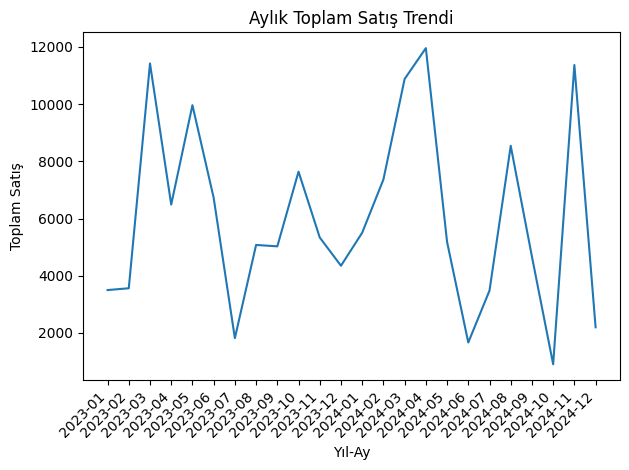

In [8]:
monthly = df.groupby("YearMonth")["Sales"].sum().reset_index()
plt.figure()
plt.plot(monthly["YearMonth"], monthly["Sales"])
plt.title("Aylık Toplam Satış Trendi")
plt.xlabel("Yıl-Ay")
plt.ylabel("Toplam Satış")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Soru 4: Kâr (Profit) dağılımı kategori bazında

Category
Furniture          10043.47
Technology          9018.70
Office Supplies     1099.89
Name: Profit, dtype: float64


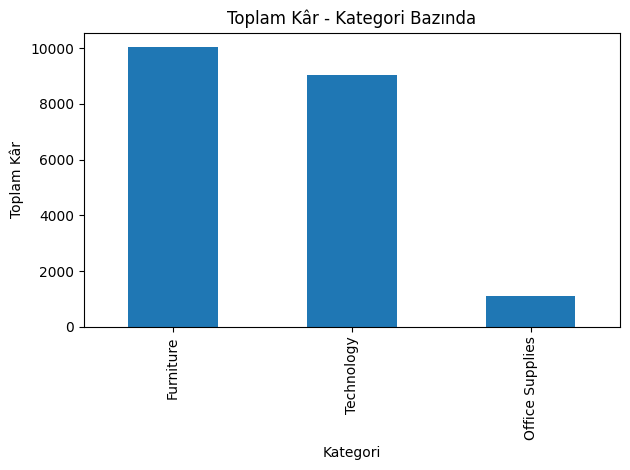

In [9]:
category_profit = df.groupby("Category")["Profit"].sum().sort_values(ascending=False)
print(category_profit)

plt.figure()
category_profit.plot(kind="bar")
plt.title("Toplam Kâr - Kategori Bazında")
plt.xlabel("Kategori")
plt.ylabel("Toplam Kâr")
plt.tight_layout()
plt.show()

### Soru 5: Zarar ettiren ürünler (Profit < 0) ve en fazla zarar eden ilk 10 ürün

In [10]:
loss_products = df[df["Profit"] < 0].groupby("ProductName")["Profit"].sum().sort_values().head(10)
loss_products

Series([], Name: Profit, dtype: float64)

## 6) Sonuçların Kaydedilmesi

- Grafiklerin `results/charts/` klasörüne kaydedilmesi
- Kısa özet/çıkarımların `results/insights.md` dosyasına yazılması

In [11]:
from pathlib import Path

charts_dir = Path("..") / "results" / "charts"
charts_dir.mkdir(parents=True, exist_ok=True)

# 6.a) Grafikleri dosyaya kaydet
# (Grafikleri tekrar çizip kaydediyoruz)
plt.figure()
category_sales.plot(kind="bar")
plt.title("Toplam Satış (Sales) - Kategori Bazında")
plt.xlabel("Kategori")
plt.ylabel("Toplam Satış")
plt.tight_layout()
plt.savefig(charts_dir / "category_sales.png")
plt.close()

plt.figure()
city_sales.plot(kind="bar")
plt.title("Toplam Satış - İlk 10 Şehir")
plt.xlabel("Şehir")
plt.ylabel("Toplam Satış")
plt.tight_layout()
plt.savefig(charts_dir / "city_sales_top10.png")
plt.close()

plt.figure()
plt.plot(monthly["YearMonth"], monthly["Sales"])
plt.title("Aylık Toplam Satış Trendi")
plt.xlabel("Yıl-Ay")
plt.ylabel("Toplam Satış")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(charts_dir / "monthly_sales_trend.png")
plt.close()

plt.figure()
category_profit.plot(kind="bar")
plt.title("Toplam Kâr - Kategori Bazında")
plt.xlabel("Kategori")
plt.ylabel("Toplam Kâr")
plt.tight_layout()
plt.savefig(charts_dir / "category_profit.png")
plt.close()

# 6.b) Kısa içgörüleri kaydet
insights_path = Path("..") / "results" / "insights.md"
top_cat = category_sales.idxmax()
top_city = city_sales.idxmax()
best_month = monthly.iloc[monthly["Sales"].idxmax()]["YearMonth"]

with open(insights_path, "w", encoding="utf-8") as f:
    f.write("# Özet İçgörüler\n\n")
    f.write(f"- En yüksek satış kategorisi: **{top_cat}**\n")
    f.write(f"- En yüksek satış yapılan şehir (ilk 10 listesinden): **{top_city}**\n")
    f.write(f"- En yüksek aylık satışın olduğu dönem: **{best_month}**\n")
    f.write("\n> Not: Bu veriler sentetiktir (örnek). Gerçek iş verilerinde sonuçlar farklı olabilir.\n")

## Tebrikler 🎉

Bu notebook ile:
- Veriyi yükledin ve inceledin,
- Temizleme ve özellik çıkarımı yaptın,
- Sık sorulan iş sorularını yanıtladın,
- Grafikler oluşturdun ve sonuçları kaydettin.

**Sıradaki adım:** `README.md` dosyasındaki talimatları izleyerek projeyi GitHub'a yükle.